<a href="https://colab.research.google.com/github/226ayush/bharat_intern_datascience/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TASK-1**

TAKE STOCK PRICE OF ANY COMPANY YOU WANT TO PREDICT USING LSTM

IMPLEMENTING LIBRARIES

In [ ]:
import pandas as pd  #for data manipulation operations
import numpy as np   #for linear algebra

#Libraries for visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle

LOADING THE DATA

In [ ]:
#Loading the required data
df=pd.read_csv('/content/archive.zip')
df.set_index('Date',inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
29/06/2010,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
30/06/2010,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
01/07/2010,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
02/07/2010,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
06/07/2010,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [ ]:
print('Number of days present in the dataset: ',df.shape[0])
print('Number of fields present in the dataset: ',df.shape[1])

Number of days present in the dataset:  3162
Number of fields present in the dataset:  6


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3162 entries, 29/06/2010 to 19/01/2023
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3162 non-null   float64
 1   High       3162 non-null   float64
 2   Low        3162 non-null   float64
 3   Close      3162 non-null   float64
 4   Adj Close  3162 non-null   float64
 5   Volume     3162 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 172.9+ KB


In [ ]:
df.describe()


,Open,High,Low,Close,Adj Close,Volume
count,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3.162000e+03
mean,59.090024,60.415403,57.622371,59.039845,59.039845,9.394769e+07
std,95.550672,97.746213,93.067484,95.420232,95.420232,8.175154e+07
min,1.076000,1.108667,0.998667,1.053333,1.053333,1.777500e+06
25%,9.037333,9.252500,8.828500,9.066833,9.066833,4.243012e+07
50%,16.294334,16.514666,16.016334,16.295666,16.295666,7.609725e+07
75%,24.965833,25.212667,24.438666,24.986833,24.986833,1.179720e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [ ]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

CHECK FOR NULL VALUES

In [ ]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

DATA PLOTTING

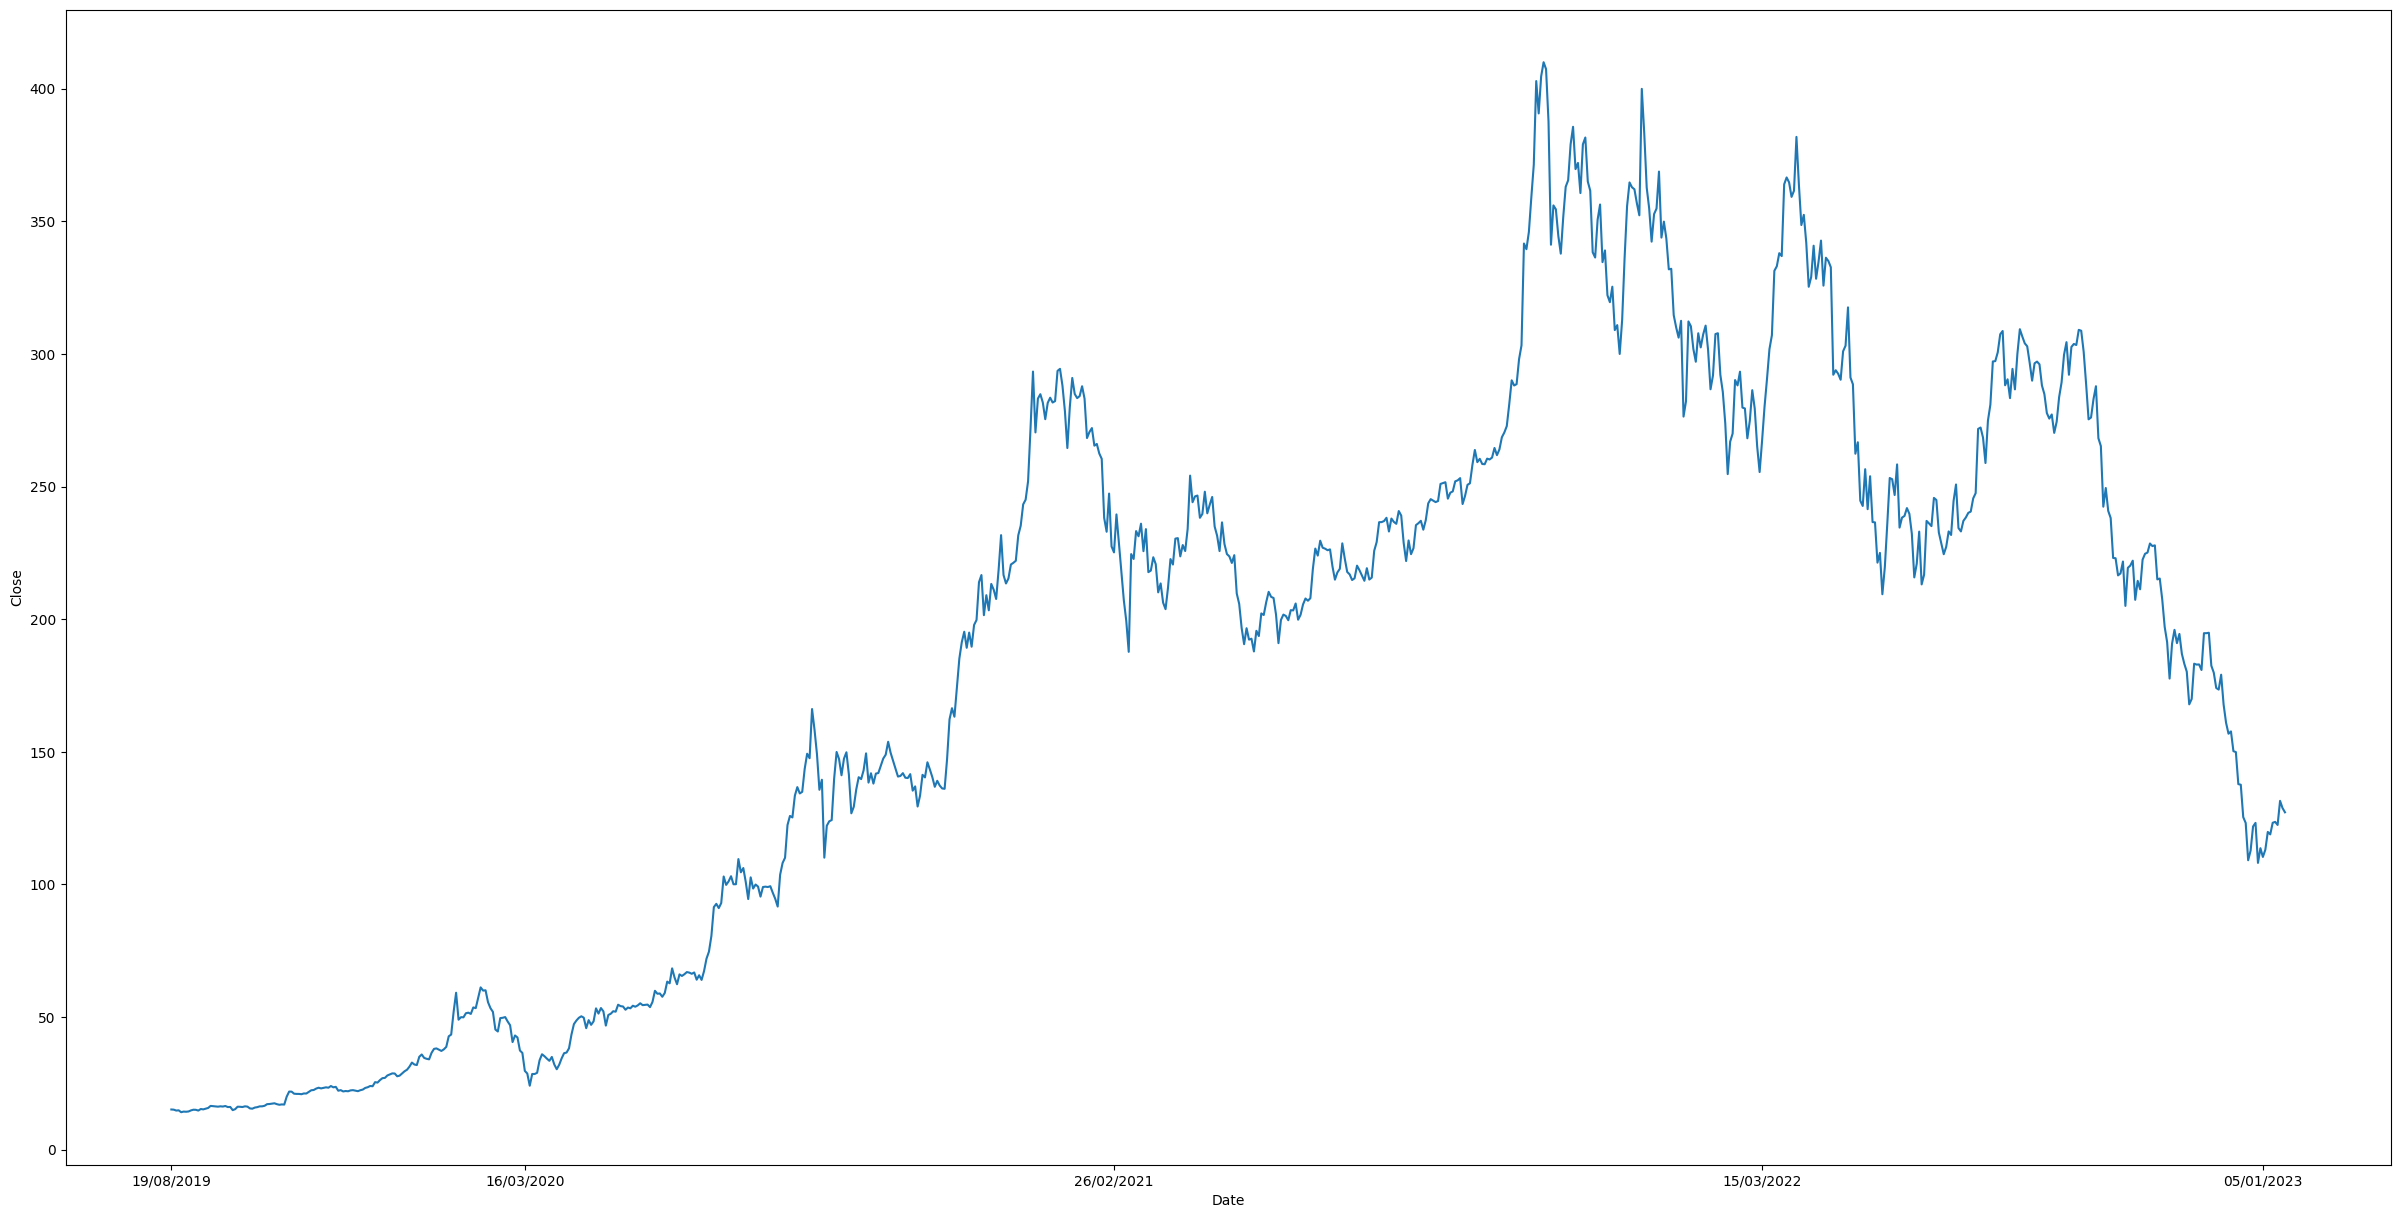

In [ ]:
data=df.iloc[2300:].copy()

plt.figure(figsize=(30,15))
ax=sns.lineplot(x=data.index,y=data['Close'])
plt.xticks(['19/08/2019','16/03/2020','26/02/2021','15/03/2022','05/01/2023'])
plt.show()

In [ ]:
data=df.iloc[2300:].copy()

names = cycle(['Stock Open Price','Stock High Price','Stock Low Price','Stock Close Price'])

fig = px.line(data, x=data.index, y=[data['Open'],data['High'], data['Low'],data['Close']],
             labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock Analysis', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.show()

MOVING AVERAGES

In [ ]:
ma_day = [30, 60, 120,150]

for ma in ma_day:
        column_name = f"MA for {ma} days"
        data[column_name] = data['Close'].rolling(ma).mean()

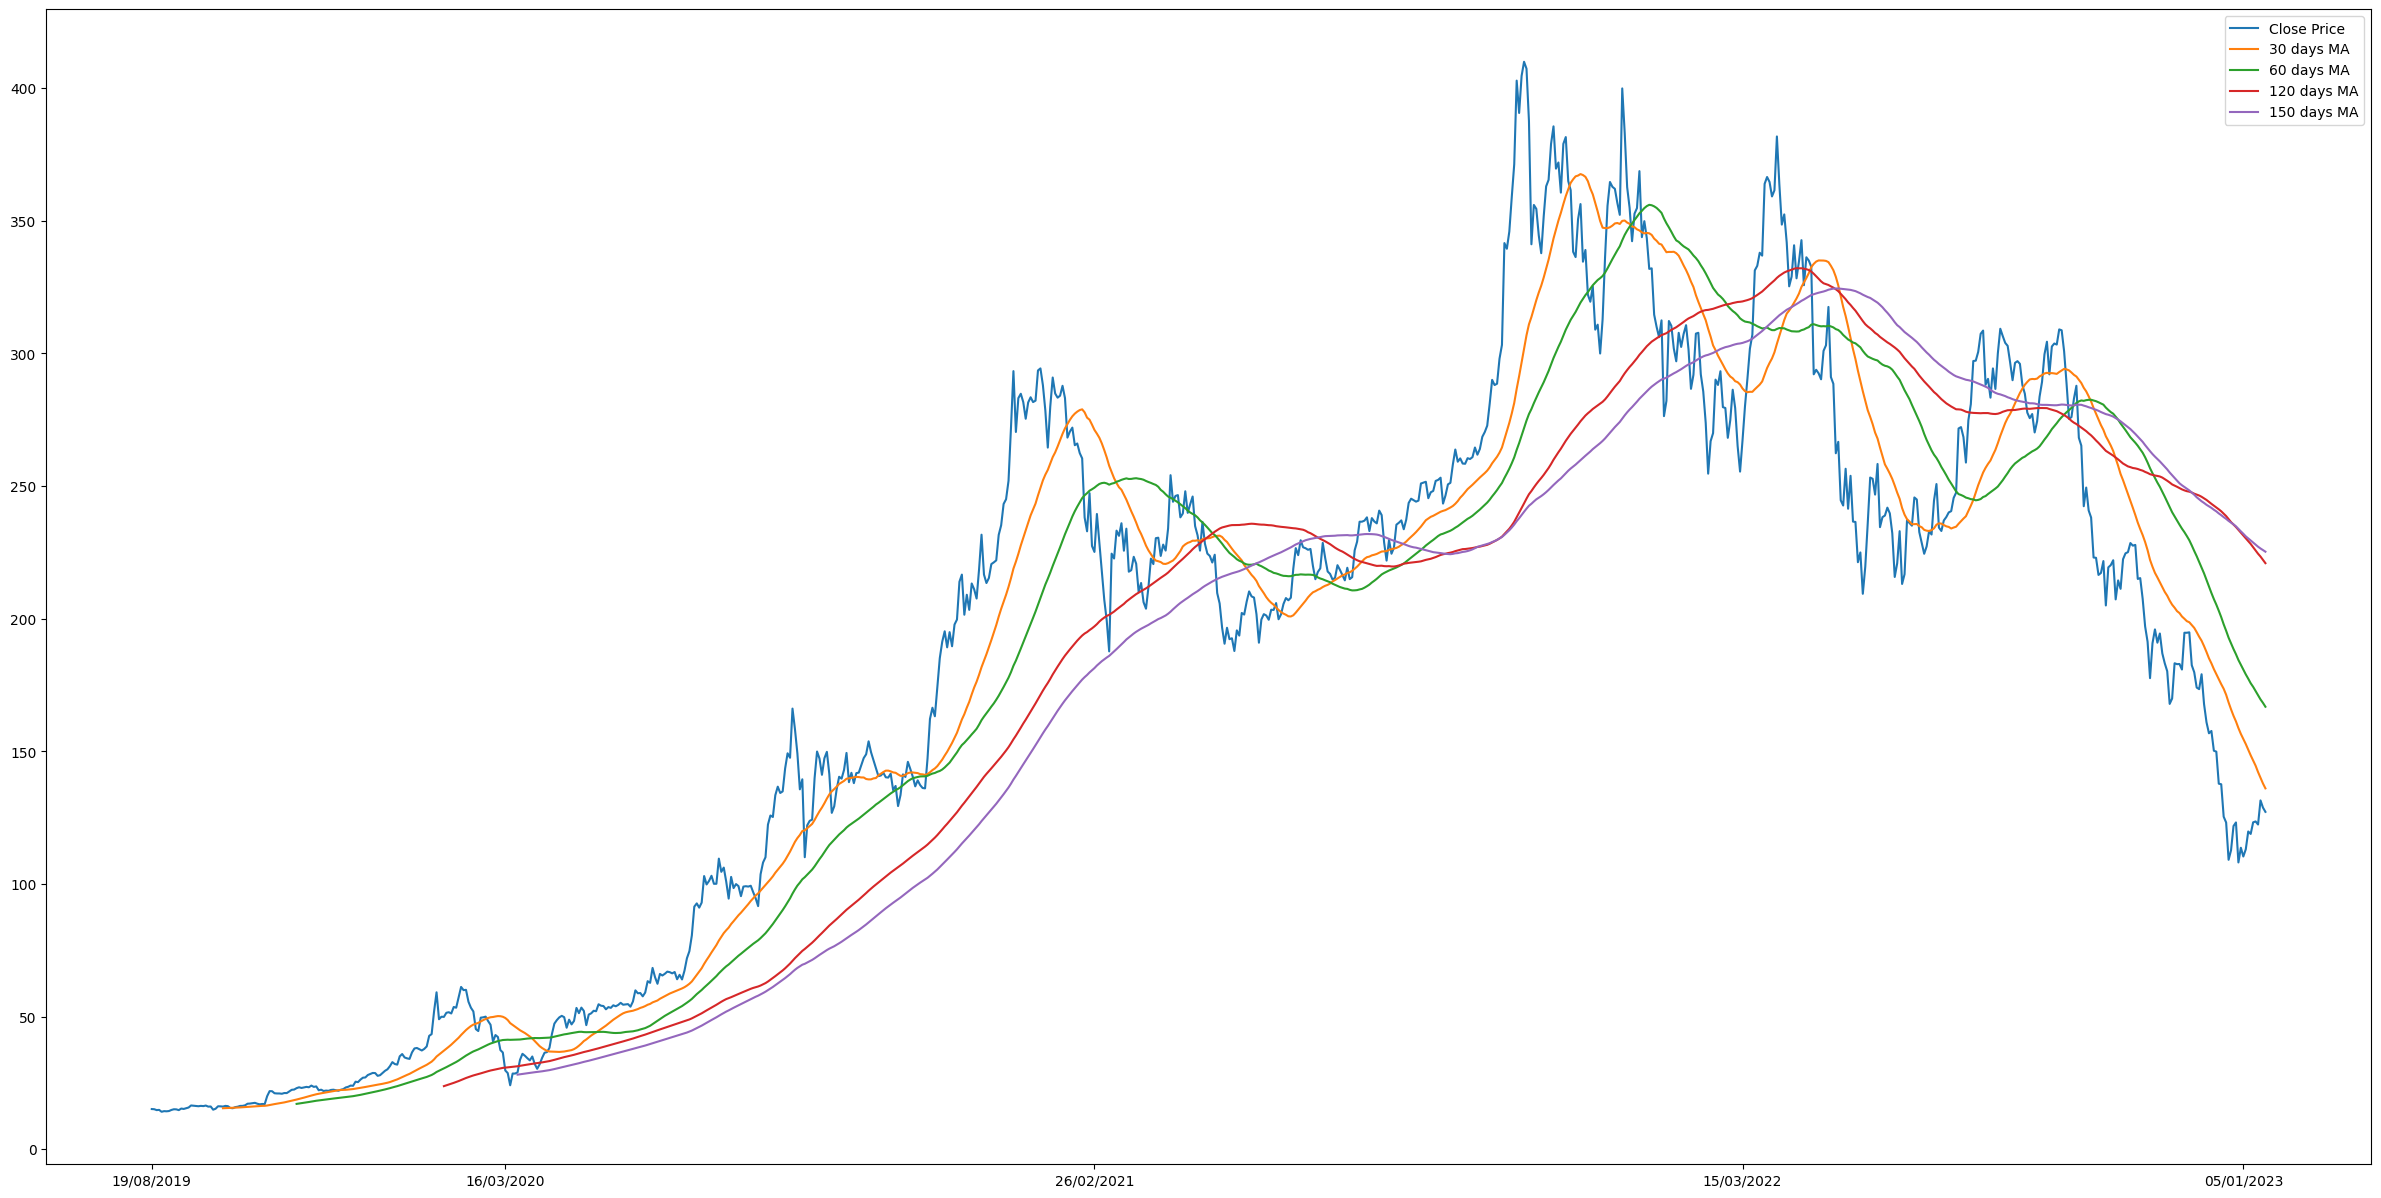

In [ ]:
plt.figure(figsize=(30,15))
plt.plot(data['Close'],label='Close Price')
plt.plot(data['MA for 30 days'],label='30 days MA')
plt.plot(data['MA for 60 days'],label='60 days MA')
plt.plot(data['MA for 120 days'],label='120 days MA')
plt.plot(data['MA for 150 days'],label='150 days MA')
plt.xticks(['19/08/2019','16/03/2020','26/02/2021','15/03/2022','05/01/2023'])
plt.legend()
plt.show()

In [ ]:
names = cycle(['Close Price','MA 30 days','MA 60 days','MA 120 days','MA 150 days'])

fig = px.line(data, x=data.index ,y=[data['Close'],data['MA for 30 days'],data['MA for 60 days'],data['MA for 120 days'], data['MA for 150 days']],labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Moving Average Analysis', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.show()

SPLITTING THE TIME-SERIES DATA

In [ ]:
# Creating a new dataframe with only 'Close'
new_df = data['Close']
new_df.index = data.index

final_df=new_df.values

train_data=final_df[0:646,]
test_data=final_df[646:,]

train_df = pd.DataFrame()
test_df = pd.DataFrame()

train_df['Close'] = train_data
train_df.index = new_df[0:646].index
test_df['Close'] = test_data
test_df.index = new_df[646:].index

In [ ]:
print("train_data: ", train_df.shape)
print("test_data: ", test_df.shape)

train_data:  (646, 1)
test_data:  (216, 1)


SCALING DATA USING MIN-MAX SCALAR

In [ ]:
# Using Min-Max scaler to scale data
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_df.reshape(-1,1))

X_train_data,y_train_data=[],[]

for i in range(60,len(train_df)):
    X_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

X_train_data,y_train_data=np.array(X_train_data),np.array(y_train_data)

X_train_data=np.reshape(X_train_data,(X_train_data.shape[0],X_train_data.shape[1],1))


MODEL BUILDING USING LSTM MODEL

In [ ]:
# Initializing the LSTM model
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_data.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train_data, y_train_data, epochs = 150, batch_size = 32);

Epoch 1/150
19/19 [==============================] - 13s 169ms/step - loss: 0.0668
Epoch 2/150
19/19 [==============================] - 3s 133ms/step - loss: 0.0097
Epoch 3/150
19/19 [==============================] - 3s 136ms/step - loss: 0.0088
Epoch 4/150
19/19 [==============================] - 2s 131ms/step - loss: 0.0071
Epoch 5/150
19/19 [==============================] - 4s 193ms/step - loss: 0.0078
Epoch 6/150
19/19 [==============================] - 3s 177ms/step - loss: 0.0061
Epoch 7/150
19/19 [==============================] - 3s 132ms/step - loss: 0.0065
Epoch 8/150
19/19 [==============================] - 3s 133ms/step - loss: 0.0072
Epoch 9/150
19/19 [==============================] - 3s 133ms/step - loss: 0.0067
Epoch 10/150
19/19 [==============================] - 4s 190ms/step - loss: 0.0063
Epoch 11/150
19/19 [==============================] - 4s 182ms/step - loss: 0.0061
Epoch 12/150
19/19 [==============================] - 3s 135ms/step - loss: 0.0054
Epoch 13/150

PREDICTIONS

In [ ]:
input_data=new_df[len(new_df)-len(test_df)-60:].values
input_data=input_data.reshape(-1,1)
input_data=scaler.transform(input_data)

In [ ]:
X_test=[]
for i in range(60,input_data.shape[0]):
    X_test.append(input_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [ ]:
predicted=model.predict(X_test)
predicted=scaler.inverse_transform(predicted)

7/7 [==============================] - 0s 38ms/step


In [ ]:
test_df['Predictions']=predicted

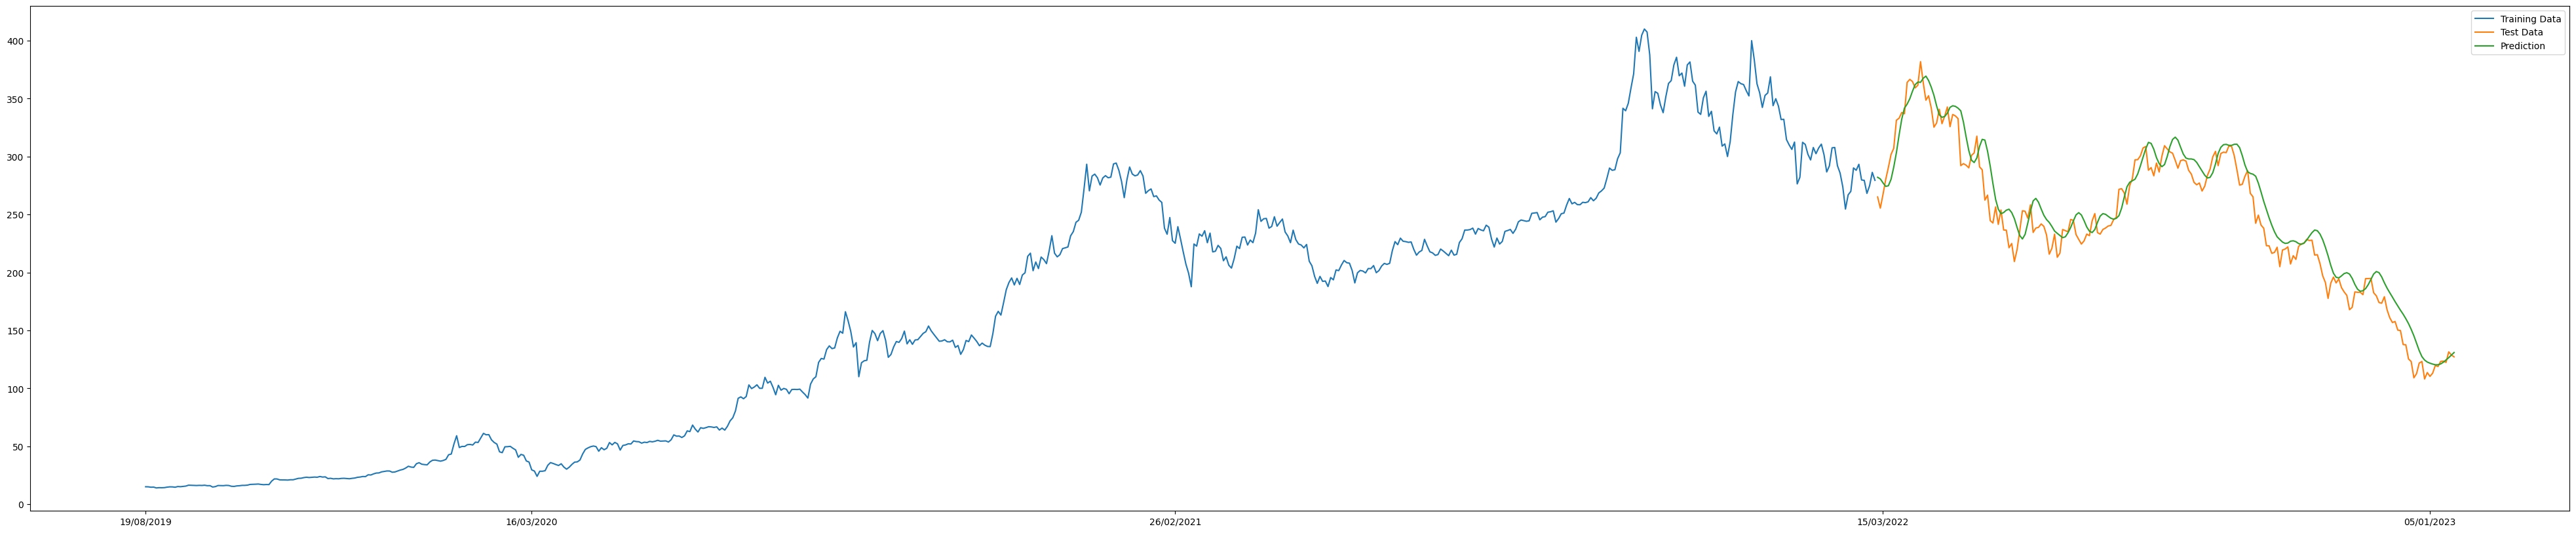

In [ ]:
plt.figure(figsize=(50,10))
plt.plot(train_df['Close'],label='Training Data')
plt.plot(test_df['Close'],label='Test Data')
plt.plot(test_df['Predictions'],label='Prediction')
plt.xticks(['19/08/2019','16/03/2020','26/02/2021','15/03/2022','05/01/2023'])
plt.legend()
plt.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.index,y=train_df['Close'],
                    mode='lines',
                    name='Training Data'))
fig.add_trace(go.Scatter(x=test_df.index,y=test_df['Close'],
                    mode='lines',
                    name='Test Data'))
fig.add_trace(go.Scatter(x=test_df.index,y=test_df['Predictions'],
                    mode='lines',
                    name='Prediction'))

In [ ]:
print('The Mean Squared Error is',mean_squared_error(test_df['Close'].values,test_df['Predictions'].values))
print('The Mean Absolute Error is',mean_absolute_error(test_df['Close'].values,test_df['Predictions'].values))
print('The Root Mean Squared Error is',np.sqrt(mean_squared_error(test_df['Close'].values,test_df['Predictions'].values)))

The Mean Squared Error is 313.2807940550312
The Mean Absolute Error is 14.319657106644241
The Root Mean Squared Error is 17.699739943146938
